In [5]:
import json
import os
import pandas as pd
from time import sleep
from threading import Thread , Event
from os.path import join, exists
from traceback import print_exc
from random import random
from datetime import datetime, timezone, timedelta, date
from api.dwx_client import dwx_client
import numpy as np
import ftplib
import gzip
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from os.path import exists
import sys
from backtesting import Strategy
from backtesting import Backtest
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#import DarwinexDownloader
#dwnx = DarwinexDownloader.Connection('Zero1140', 'xLX0u1S93cX20Y') # clase
#data = dwnx.download('EURUSD', "01-10-2017", "20-06-2024", '5m')
ftp = ftplib.FTP('tickdata.darwinex.com', 'Zero1140', 'P63SY6HgTY1Til')

In [ ]:
fecha_inicio = "10-06-2023"
fecha_fin = "20-06-2024"
TICKER ='EURUSD'
# Creo la carpeta data para guardar los datos
try:
  os.mkdir('dataEURUSD')
except: 
  pass

# Preparo las fechas para trabajar más fácil con ellas
fecha_inicio_split = fecha_inicio.split("-")
fecha_fin_split = fecha_fin.split("-")
fecha_inicio_datetime = date(int(fecha_inicio_split[2]), int(fecha_inicio_split[1]), int(fecha_inicio_split[0]))
fecha_fin_datetime = date(int(fecha_fin_split[2]), int(fecha_fin_split[1]), int(fecha_fin_split[0]))

# Calculo la diferencia entre las fechas para ir hacíando el bucle
# que va descargar todos los datos
delta = fecha_fin_datetime - fecha_inicio_datetime
for i in range(delta.days + 1):
    day = fecha_inicio_datetime + timedelta(days=i)
    # Pongo para que descargue todas las horas para casos de divisas
    # Si no encuentra el fichero (al ser una acción normal) continua
    for i in range(24):
      hora = str(i).rjust(2, '0')
      try:
        download_file = TICKER+"_BID_"+str(day.year)+"-"+str(day.month).rjust(2, '0')+"-"+str(day.day).rjust(2, '0')+"_"+hora+".log.gz"
        ftp.retrbinary("RETR /"+TICKER+"/"+download_file ,open("dataEURUSD/"+download_file, 'wb').write)
        print(f"Downloaded: {download_file}, Size: {os.path.getsize('dataEURUSD/'+download_file)} bytes")
      
      except Exception as e:
        if str(e).startswith('550'):
                print(f"File not found: {download_file}")
        else:
                print(f"Failed to download {download_file}: {e}")
      except Exception as e:
            print(f"Failed to download {download_file}: {e}")

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("dataEURUSD") if isfile(join("dataEURUSD", f))]

appended_data = []

for stock_file in onlyfiles:
  with open("dataEURUSD/"+stock_file, 'rb') as fd:
      gzip_fd = gzip.GzipFile(fileobj=fd)
      appended_data.append(pd.read_csv(gzip_fd,names=["Date","Price","Size"]))

df_stock = pd.concat(appended_data)
df_stock['Date'] = pd.to_datetime(df_stock['Date'],unit='ms')

In [ ]:
df_stock

In [ ]:
print(df_stock.columns)

In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock = df_stock.set_index('Date')
stock_5min_ohlc = df_stock['Price'].resample('5Min').ohlc()
stock_5min_ohlc['Volume'] = df_stock['Size'].resample('5Min').sum()
df = stock_5min_ohlc
df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)
df=df[df.High!=df.Low]

In [ ]:
df["VWAP"]=ta.vwap(df.High, df.Low, df.Close, df.Volume)
df['RSI']=ta.rsi(df.Close, length=16)
my_bbands = ta.bbands(df.Close, length=14, std=2.0)
df=df.join(my_bbands)
df.dropna(inplace=True)

In [ ]:
VWAPsignal = [0]*len(df)
backcandles = 15

for row in range(backcandles, len(df)):
    upt = 1
    dnt = 1
    for i in range(row-backcandles, row+1):
        if max(df.Open[i], df.Close[i])>=df.VWAP[i]:
            dnt=0
        if min(df.Open[i], df.Close[i])<=df.VWAP[i]:
            upt=0
    if upt==1 and dnt==1:
        VWAPsignal[row]=3
    elif upt==1:
        VWAPsignal[row]=2
    elif dnt==1:
        VWAPsignal[row]=1

df['VWAPSignal'] = VWAPsignal

In [ ]:
def TotalSignal(l):
    if (df.VWAPSignal[l]==2
        and df.Close[l]<=df['BBL_14_2.0'][l]
        and df.RSI[l]<45):
            return 2
    if (df.VWAPSignal[l]==1
        and df.Close[l]>=df['BBU_14_2.0'][l]
        and df.RSI[l]>55):
            return 1 
    return 0
        
TotSignal = [0]*len(df)
for row in range(backcandles, len(df)): #careful backcandles used previous cell
    TotSignal[row] = TotalSignal(row)
df['TotalSignal'] = TotSignal

In [ ]:
df[df.TotalSignal!=0].count()

In [ ]:
import numpy as np
def pointposbreak(x):
    if x['TotalSignal']==1:
        return x['High']+1e-4
    elif x['TotalSignal']==2:
        return x['Low']-1e-4
    else:
        return np.nan

df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=10400
dfpl = df[:]
dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.VWAP, 
                           line=dict(color='blue', width=1), 
                           name="VWAP"), 
                go.Scatter(x=df.index, y=dfpl['BBL_14_2.0'], 
                           line=dict(color='green', width=1), 
                           name="BBL"),
                go.Scatter(x=df.index, y=dfpl['BBU_14_2.0'], 
                           line=dict(color='green', width=1), 
                           name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=10, color="MediumPurple"),
                name="Signal")
fig.show()

In [ ]:
dfpl = df[:75000].copy()
import pandas_ta as ta
dfpl['ATR']=ta.atr(dfpl.High, dfpl.Low, dfpl.Close, length=7)
#help(ta.atr)
def SIGNAL():
    return dfpl.TotalSignal

In [ ]:
dfpl = dfpl.dropna(axis=1, how='all')
dfpl = dfpl.interpolate(method='linear')  # Rellenar valores NaN usando interpolación
dfpl = dfpl.dropna(subset=['Open', 'High', 'Low', 'Close'])
dfpl

In [ ]:
bt.plot(show_legend=False)

In [7]:
class tick_processor():

    def __init__(self, MT4_directory_path, 
                 sleep_delay=0.005,             # 5 ms for time.sleep()
                 max_retry_command_seconds=10,  # retry to send the commend for 10 seconds if not successful. 
                 verbose=True
                 ):

        # if true, it will randomly try to open and close orders every few seconds. 
        self.open_test_trades = True

        self.last_open_time = datetime.now(timezone.utc)
        self.last_modification_time = datetime.now(timezone.utc)

        self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, 
                              max_retry_command_seconds, verbose=verbose)
        sleep(1)

        self.dwx.start()
        
        # account information is stored in self.dwx.account_info.
        print("Account info:", self.dwx.account_info)

        # subscribe to tick data:
        self.dwx.subscribe_symbols(['EURUSD', 'GBPUSD'])

        # subscribe to bar data:
        self.dwx.subscribe_symbols_bar_data([['EURUSD', 'M15'], ['GBPJPY', 'M5'], ['AUDCAD', 'M1']])

        # request historic data:

        end = datetime.now(timezone.utc) + timedelta(hours=4)
        start = end - timedelta(days=5)  # últimos 100 días
        self.dwx.get_historic_data('EURUSD', 'M5', start.timestamp(), end.timestamp())    
  
    def on_historic_data(self, symbol, time_frame, data):
        data_list = []

        for date_str, values in data.items():
            date = datetime.strptime(date_str, "%Y.%m.%d %H:%M")
            data_dict = {
                'Date': date,
                'Open': values['open'],
                'High': values['high'],
                'Low': values['low'],
                'Close': values['close'],
                'Tick_volume': values['tick_volume']
            }
            data_list.append(data_dict)
        
        self.dfstream = pd.DataFrame(data_list)
        print("Historic DataFrame:")
        print(self.dfstream)
        
        self.data_event.set()  # Signal that data is ready

    def on_tick(self, symbol, bid, ask):

        now = datetime.now(timezone.utc)

        print('on_tick:', now, symbol, bid, ask)

        # to test trading. 
        # this will randomly try to open and close orders every few seconds. 
        if self.open_test_trades:
            if now > self.last_open_time + timedelta(seconds=3):

                self.last_open_time = now
                
                order_type = 'buy'
                price = ask
                if random() > 0.5:
                    order_type = 'sell'
                    price = bid

                self.dwx.open_order(symbol=symbol, order_type=order_type, 
                                    price=price, lots=0.5)

            if now > self.last_modification_time + timedelta(seconds=10):

                self.last_modification_time = now

                for ticket in self.dwx.open_orders.keys():
                    self.dwx.close_order(ticket, lots=0.1)

            if len(self.dwx.open_orders) >= 10:
                self.dwx.close_all_orders()
                # self.dwx.close_orders_by_symbol('GBPUSD')
                # self.dwx.close_orders_by_magic(0)


    def on_bar_data(self, symbol, time_frame, time, open_price, high, low, close_price, tick_volume):
        
        print('on_bar_data:', symbol, time_frame, datetime.now(timezone.utc), time, open_price, high, low, close_price)

    
    def on_historic_data(self, symbol, time_frame, data):
        
        # you can also access the historic data via self.dwx.historic_data. 
        print('historic_data:', symbol, time_frame, f'{len(data)} bars')


    def on_historic_trades(self):

        print(f'historic_trades: {len(self.dwx.historic_trades)}')
    

    def on_message(self, message):

        if message['type'] == 'ERROR':
            print(message['type'], '|', message['error_type'], '|', message['description'])
        elif message['type'] == 'INFO':
            print(message['type'], '|', message['message'])


    # triggers when an order is added or removed, not when only modified. 
    def on_order_event(self):
        
        print(f'on_order_event. open_orders: {len(self.dwx.open_orders)} open orders')



MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'

processor = tick_processor(MT4_files_dir)

while processor.dwx.ACTIVE:
    sleep(1)

Account info: {'name': 'Guillermo Fabian Guerra Algañaraz', 'number': -1294900752, 'currency': 'EUR', 'leverage': 200, 'free_margin': 2580.43, 'balance': 6517.46, 'equity': 6466.8}
on_tick: 2024-08-08 21:13:48.209561+00:00 EURUSD 1.09153 1.09181
on_tick: 2024-08-08 21:13:48.209561+00:00 GBPUSD 1.2735 1.27484
on_bar_data: AUDCAD M1 2024-08-08 21:13:48.210079+00:00 2024.08.09 00:12 0.90486 0.90491 0.90486 0.90491
INFO | Successfully sent order: GBPUSD, buy, 0.50, 1.27484
INFO | Successfully closed order: 2029053051, EURUSD, 0.10
INFO | Successfully closed order: 2029053049, GBPUSD, 0.10
INFO | Successfully closed order: 2029053048, EURUSD, 0.10
New order:  {'magic': 0, 'symbol': 'GBPUSD', 'lots': 0.5, 'type': 'buy', 'open_price': 1.27484, 'open_time': '2024.08.09 00:13:46', 'SL': 0.0, 'TP': 0.0, 'pnl': -61.38, 'swap': 0.0, 'comment': ''}
on_order_event. open_orders: 4 open orders
INFO | Successfully subscribed to: EURUSD, GBPUSD
on_bar_data: EURUSD M15 2024-08-08 21:13:48.840067+00:00 20

KeyboardInterrupt: 

on_tick: 2024-08-08 21:17:36.163039+00:00 GBPUSD 1.27416 1.27477
on_tick: 2024-08-08 21:17:38.424778+00:00 EURUSD 1.09156 1.09187
on_tick: 2024-08-08 21:17:38.425296+00:00 GBPUSD 1.27416 1.27477
on_tick: 2024-08-08 21:17:40.290561+00:00 GBPUSD 1.27416 1.27476
ERROR | WRONG_FORMAT_END_IDENTIFIER | End identifier not found for command: <:98|OPEN_ORDER|GBPUSD,buy,0.5,1.27476,0,0,0,,0:>>
ERROR | WRONG_FORMAT_END_IDENTIFIER | End identifier not found for command: <:99|CLOSE_ORDER|2029053141,0.1:>>
INFO | Successfully closed order: 2029053139, GBPUSD, 0.10
INFO | Successfully sent order: GBPUSD, buy, 0.50, 1.27477
INFO | Successfully closed order: 2029053106, GBPUSD, 0.10
INFO | Successfully closed order: 2029053138, GBPUSD, 0.10
Order removed:  {'magic': 0, 'symbol': 'GBPUSD', 'lots': 0.1, 'type': 'sell', 'open_price': 1.27385, 'open_time': '2024.08.09 00:15:48', 'SL': 0.0, 'TP': 0.0, 'pnl': -8.33, 'swap': 0.0, 'comment': ''}
New order:  {'magic': 0, 'symbol': 'GBPUSD', 'lots': 0.5, 'type':

In [2]:
class getdf:
    def __init__(self, MT4_directory_path, sleep_delay=1, max_retry_command_seconds=10, verbose=True):
        self.data_event = Event()
        self.dfstream = None

        self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, max_retry_command_seconds, verbose=verbose)
        sleep(1)
        self.dwx.start()
        print("Account info:", self.dwx.account_info)
        self.dwx.subscribe_symbols(['EURUSD'])

    def fetch_historic_data(self, symbol, time_frame, n):
        if not isinstance(n, int):
            print("ERROR: 'n' must be an integer representing the number of days.")
            return None
        end = datetime.now(timezone.utc)
        start = end - timedelta(days=n)
        data = self.dwx.get_historic_data(symbol, time_frame, start.timestamp(), end.timestamp())
        self.on_historic_data(symbol, time_frame, data)

    def on_historic_data(self, symbol, time_frame, data):
        if data is None or not isinstance(data, dict):
            print("ERROR: No data returned or invalid data format.")
            return None

        data_list = []
        for date_str, values in data.items():
            date = datetime.strptime(date_str, "%Y.%m.%d %H:%M")
            data_dict = {
                'Date': date,
                'Open': values['open'],
                'High': values['high'],
                'Low': values['low'],
                'Close': values['close'],
                'Tick_volume': values['tick_volume']
            }
            data_list.append(data_dict)

        df = pd.DataFrame(data_list)
        df = df[df.High != df.Low]
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df["VWAP"] = ta.vwap(df.High, df.Low, df.Close, df.Tick_volume)
        df['RSI'] = ta.rsi(df.Close, length=16)
        my_bbands = ta.bbands(df.Close, length=14, std=2.0)
        df = df.join(my_bbands)
        df.dropna(inplace=True)
        print('FASE1')

        VWAPsignal = [0] * len(df)
        backcandles = 15

        for row in range(backcandles, len(df)):
            upt = 1
            dnt = 1
            for i in range(row - backcandles, row + 1):
                if max(df.Open.iloc[i], df.Close.iloc[i]) >= df.VWAP.iloc[i]:
                    dnt = 0
                if min(df.Open.iloc[i], df.Close.iloc[i]) <= df.VWAP.iloc[i]:
                    upt = 0
            if upt == 1 and dnt == 1:
                VWAPsignal[row] = 3
            elif upt == 1:
                VWAPsignal[row] = 2
            elif dnt == 1:
                VWAPsignal[row] = 1

        df['VWAPSignal'] = VWAPsignal
        print(df)
        self.dfstream = df
        self.data_event.set()  # Signal that data is ready

    def on_message(self, message):
        if message['type'] == 'ERROR':
            print(message['type'], '|', message['error_type'], '|', message['description'])
        elif message['type'] == 'INFO':
            print(message['type'], '|', message['message'])

    def get_data_frame(self):
        self.data_event.wait()  # Wait until data is ready
        return self.dfstream

    def get_dwx(self):
        return self.dwx

# Example usage
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

processor = getdf(MT4_files_dir)

# Fetch and process historical data
processor.fetch_historic_data('EURUSD', 'M5', 300)

# Wait for data to be processed and retrieve the DataFrame
df = processor.get_data_frame()
print(df)

Account info: {'name': 'Guillermo Fabian Guerra Algañaraz', 'number': -1294900752, 'currency': 'EUR', 'leverage': 200, 'free_margin': 7322.26, 'balance': 7322.26, 'equity': 7322.26}
ERROR: No data returned or invalid data format.
INFO | Successfully subscribed to: EURUSD


Exception in thread Thread-6 (check_market_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure


INFO | Successfully read historic data for EURUSD_M5.


    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 258, in check_market_data
    self.event_handler.on_tick(symbol,
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_tick'


FASE1
                        Open     High      Low    Close  Tick_volume  \
Date                                                                   
2023-10-03 12:20:00  1.04872  1.04872  1.04839  1.04852        160.0   
2023-10-03 12:25:00  1.04852  1.04853  1.04830  1.04847        157.0   
2023-10-03 12:30:00  1.04847  1.04895  1.04832  1.04853        229.0   
2023-10-03 12:35:00  1.04853  1.04901  1.04843  1.04888        221.0   
2023-10-03 12:40:00  1.04889  1.04908  1.04873  1.04888        238.0   
...                      ...      ...      ...      ...          ...   
2024-07-29 10:35:00  1.08526  1.08560  1.08519  1.08557        311.0   
2024-07-29 10:40:00  1.08557  1.08560  1.08509  1.08510        277.0   
2024-07-29 10:45:00  1.08511  1.08514  1.08473  1.08477        200.0   
2024-07-29 10:50:00  1.08477  1.08480  1.08441  1.08450        358.0   
2024-07-29 10:55:00  1.08450  1.08461  1.08433  1.08446        282.0   

                         VWAP        RSI  BBL_14_2.0  BBM

KeyboardInterrupt: 

In [2]:
class getdf():
    def __init__(self, MT4_directory_path, 
                 sleep_delay=1,             # 5 ms for time.sleep()
                 max_retry_command_seconds=10,  # retry to send the commend for 10 seconds if not successful. 
                 verbose=True, ):
        self.data_event = Event()
        self.dfstream = None

        self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, 
                              max_retry_command_seconds, verbose=verbose)
        sleep(1)
        self.dwx.start()
       
        end = datetime.now(timezone.utc + timedelta(hours=4))
        start = end - timedelta(days=5)  # últimos 100 días
        self.dwx.get_historic_data('EURUSD', 'M5', start.timestamp(), end.timestamp())    
  
    local_timezone = datetime.now().astimezone().tzinfo
    print("Zona horaria local:", local_timezone)
    def on_historic_data(self, symbol, time_frame, data):
        data_list = []

        for date_str, values in data.items():
            date = datetime.strptime(date_str, "%Y.%m.%d %H:%M")
            data_dict = {
                'Date': date,
                'Open': values['open'],
                'High': values['high'],
                'Low': values['low'],
                'Close': values['close'],
                'Tick_volume': values['tick_volume']
            }
            data_list.append(data_dict)
        
        self.dfstream = pd.DataFrame(data_list)
        print("Historic DataFrame:")
        print(self.dfstream)
        
        self.data_event.set()  # Signal that data is ready
        
    def on_message(self, message):
        if message['type'] == 'ERROR':
            print(message['type'], '|', message['error_type'], '|', message['description'])
        elif message['type'] == 'INFO':
            print(message['type'], '|', message['message'])
            
    def get_data_frame(self):
        self.data_event.wait()  # Wait until data is ready
        return self.dfstream

# Example usage
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

processor = getdf(MT4_files_dir)

# Wait for data to be processed and retrieve the DataFrame
df = processor.get_data_frame()

Zona horaria local: Hora de verano GMT


TypeError: unsupported operand type(s) for +: 'datetime.timezone' and 'datetime.timedelta'

In [3]:
class getdf():
    def __init__(self, MT4_directory_path, 
                 sleep_delay=1,             # 5 ms for time.sleep()
                 max_retry_command_seconds=10,  # retry to send the commend for 10 seconds if not successful. 
                 verbose=True, ):
        self.data_event = Event()
        self.dfstream = None

        self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, 
                              max_retry_command_seconds, verbose=verbose)
        sleep(1)
        self.dwx.start()
        
        end = datetime.now(timezone.utc) + timedelta(hours=4)
        start = end - timedelta(days=300)  # last 100 days
        self.dwx.get_historic_data('AUDCAD', 'M5', start.timestamp(), end.timestamp())      

    def on_historic_data(self, symbol, time_frame, data):
        data_list = []

        for date_str, values in data.items():
            date = datetime.strptime(date_str, "%Y.%m.%d %H:%M")
            data_dict = {
                'Date': date,
                'Open': values['open'],
                'High': values['high'],
                'Low': values['low'],
                'Close': values['close'],
                'Tick_volume': values['tick_volume']
            }
            data_list.append(data_dict)
        
        self.dfstream = pd.DataFrame(data_list)
        print("Historic DataFrame:")
        print(self.dfstream)
        
        self.data_event.set()  # Signal that data is ready
        
    

        
    def on_message(self, message):
        if message['type'] == 'ERROR':
            print(message['type'], '|', message['error_type'], '|', message['description'])
        elif message['type'] == 'INFO':
            print(message['type'], '|', message['message'])
            
    def get_data_frame(self):
        self.data_event.wait()  # Wait until data is ready
        return self.dfstream

    

# Example usage
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

processor = getdf(MT4_files_dir)

# Wait for data to be processed and retrieve the DataFrame
df = processor.get_data_frame()


INFO | Successfully read historic data for AUDCAD_M5.
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-09 00:05:00  0.86897  0.86907  0.86893  0.86902         11.0
1     2023-10-09 00:10:00  0.86902  0.86907  0.86902  0.86907          5.0
2     2023-10-09 00:15:00  0.86899  0.86962  0.86899  0.86917         25.0
3     2023-10-09 00:20:00  0.86917  0.86929  0.86913  0.86926          9.0
4     2023-10-09 00:25:00  0.86926  0.86980  0.86926  0.86962         22.0
...                   ...      ...      ...      ...      ...          ...
61114 2024-08-02 17:30:00  0.90421  0.90444  0.90346  0.90356       2242.0
61115 2024-08-02 17:35:00  0.90357  0.90376  0.90300  0.90302       1900.0
61116 2024-08-02 17:40:00  0.90303  0.90337  0.90276  0.90328       1965.0
61117 2024-08-02 17:45:00  0.90328  0.90362  0.90301  0.90326       2010.0
61118 2024-08-02 17:50:00  0.90325  0.90344  0.90324  0.90338        113.0

[61119 rows x 6 columns]


In [4]:
class AnalyzeData:
    def __init__(self, data_processor, MT4_directory_path=None, sleep_delay=0.100, max_retry_command_seconds=10, verbose=True):
        self.open_test_trades = False
        self.last_open_time = datetime.now(timezone.utc)
        self.last_modification_time = datetime.now(timezone.utc)
        self.data_processor = data_processor
        
        if MT4_directory_path:
            self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, max_retry_command_seconds, verbose=verbose)
            sleep(1)
            self.dwx.start()
            print("Account info:", self.dwx.account_info)
            self.dwx.subscribe_symbols(['EURUSD'])

    def analyze(self):
        original_df = self.data_processor.get_data_frame()
        df = original_df.copy()
        df = df[df.High != df.Low]
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df["VWAP"] = ta.vwap(df.High, df.Low, df.Close, df.Tick_volume)
        df['RSI'] = ta.rsi(df.Close, length=16)
        my_bbands = ta.bbands(df.Close, length=14, std=2.0)
        df = df.join(my_bbands)
        df.dropna(inplace=True)
        print('FASE1')
        
        VWAPsignal = [0] * len(df)
        backcandles = 15

        for row in range(backcandles, len(df)):
            upt = 1
            dnt = 1
            for i in range(row-backcandles, row+1):
                if max(df.Open[i], df.Close[i]) >= df.VWAP[i]:
                    dnt = 0
                if min(df.Open[i], df.Close[i]) <= df.VWAP[i]:
                    upt = 0
            if upt == 1 and dnt == 1:
                VWAPsignal[row] = 3
            elif upt == 1:
                VWAPsignal[row] = 2
            elif dnt == 1:
                VWAPsignal[row] = 1

        df['VWAPSignal'] = VWAPsignal
        
        self.TotalSignal(df)
        return df  # Agregar esta línea para devolver el DataFrame modificado

    def TotalSignal(self, df):
        def calculate_signal(l):
            if df.VWAPSignal[l] == 2 and df.Close[l] <= df['BBL_14_2.0'][l] and df.RSI[l] < 45:
                return 2
            if df.VWAPSignal[l] == 1 and df.Close[l] >= df['BBU_14_2.0'][l] and df.RSI[l] > 55:
                return 1
            return 0

        TotSignal = [0] * len(df)
        backcandles = 15
        for row in range(backcandles, len(df)):
            TotSignal[row] = calculate_signal(row)
        df['TotalSignal'] = TotSignal
        df[df.TotalSignal != 0].count()
        self.pointposbreak(df)

    def pointposbreak(self, df):
        def calculate_pointposbreak(x):
            if x['TotalSignal'] == 1:
                return x['High'] + 1e-4
            elif x['TotalSignal'] == 2:
                return x['Low'] - 1e-4
            else:
                return np.nan
        df['pointposbreak'] = df.apply(lambda row: calculate_pointposbreak(row), axis=1)
        df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=7)
        print('FASE2')
        print(df)
        return df
    
        
# Uso de las clases
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()


processor = getdf(MT4_files_dir)
analyzer = AnalyzeData(processor, MT4_files_dir)  # Pasar la instancia de getdf a la nueva clase

# Esperar a que los datos estén listos y luego realizar el análisis

df_pointposbreak = analyzer.analyze()



Account info: {'name': 'Guillermo Fabian Guerra Algañaraz', 'number': -1294900752, 'currency': 'EUR', 'leverage': 200, 'free_margin': 6541.79, 'balance': 6541.79, 'equity': 6541.79}


Exception in thread Thread-21 (check_market_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Thread-20 (check_messages):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File 

INFO | Successfully read historic data for AUDCAD_M5.
INFO | Successfully subscribed to: EURUSD


Exception in thread Thread-11 (check_market_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 258, in check_market_data
    self.event_handler.on_tick(symbol,
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_tick'


INFO | Successfully read historic data for AUDCAD_M5.
INFO | Successfully subscribed to: EURUSD
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-09 00:05:00  0.86897  0.86907  0.86893  0.86902         11.0
1     2023-10-09 00:10:00  0.86902  0.86907  0.86902  0.86907          5.0
2     2023-10-09 00:15:00  0.86899  0.86962  0.86899  0.86917         25.0
3     2023-10-09 00:20:00  0.86917  0.86929  0.86913  0.86926          9.0
4     2023-10-09 00:25:00  0.86926  0.86980  0.86926  0.86962         22.0
...                   ...      ...      ...      ...      ...          ...
61114 2024-08-02 17:30:00  0.90421  0.90444  0.90346  0.90356       2242.0
61115 2024-08-02 17:35:00  0.90357  0.90376  0.90300  0.90302       1900.0
61116 2024-08-02 17:40:00  0.90303  0.90337  0.90276  0.90328       1965.0
61117 2024-08-02 17:45:00  0.90328  0.90362  0.90301  0.90326       2010.0
61118 2024-08-02 17:50:00  0.90325  0.90347  0.90324  0.903

Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-09 00:05:00  0.86897  0.86907  0.86893  0.86902         11.0
1     2023-10-09 00:10:00  0.86902  0.86907  0.86902  0.86907          5.0
2     2023-10-09 00:15:00  0.86899  0.86962  0.86899  0.86917         25.0
3     2023-10-09 00:20:00  0.86917  0.86929  0.86913  0.86926          9.0
4     2023-10-09 00:25:00  0.86926  0.86980  0.86926  0.86962         22.0
...                   ...      ...      ...      ...      ...          ...
61114 2024-08-02 17:30:00  0.90421  0.90444  0.90346  0.90356       2242.0
61115 2024-08-02 17:35:00  0.90357  0.90376  0.90300  0.90302       1900.0
61116 2024-08-02 17:40:00  0.90303  0.90337  0.90276  0.90328       1965.0
61117 2024-08-02 17:45:00  0.90328  0.90362  0.90301  0.90326       2010.0
61118 2024-08-02 17:50:00  0.90325  0.90347  0.90324  0.90344        287.0

[61119 rows x 6 columns]
INFO | Successfully read historic data for EURUSD_M5.


C:\Users\guill\AppData\Local\Temp\ipykernel_22120\104899990.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if max(df.Open[i], df.Close[i]) >= df.VWAP[i]:
C:\Users\guill\AppData\Local\Temp\ipykernel_22120\104899990.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if min(df.Open[i], df.Close[i]) <= df.VWAP[i]:
C:\Users\guill\AppData\Local\Temp\ipykernel_22120\104899990.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if 

FASE2
                        Open     High      Low    Close  Tick_volume  \
Date                                                                   
2023-10-09 01:25:00  0.86888  0.86923  0.86880  0.86904        521.0   
2023-10-09 01:30:00  0.86902  0.86942  0.86896  0.86936        703.0   
2023-10-09 01:35:00  0.86937  0.86968  0.86921  0.86926        534.0   
2023-10-09 01:40:00  0.86924  0.86945  0.86917  0.86927        536.0   
2023-10-09 01:45:00  0.86926  0.86947  0.86916  0.86917        456.0   
...                      ...      ...      ...      ...          ...   
2024-08-02 17:30:00  0.90421  0.90444  0.90346  0.90356       2242.0   
2024-08-02 17:35:00  0.90357  0.90376  0.90300  0.90302       1900.0   
2024-08-02 17:40:00  0.90303  0.90337  0.90276  0.90328       1965.0   
2024-08-02 17:45:00  0.90328  0.90362  0.90301  0.90326       2010.0   
2024-08-02 17:50:00  0.90325  0.90347  0.90324  0.90344        287.0   

                         VWAP        RSI  BBL_14_2.0  BBM

In [5]:

df = df_pointposbreak.copy()


In [6]:
def SIGNAL():
        return df.TotalSignal
class MyStrat(Strategy):
        initsize = 0.99
        mysize = initsize
        slatr = 1.4  # Default value, will be optimized
        TPSLRatio = 1.0  # Default value, will be optimized
        def init(self):
            super().init()
            self.signal1 = self.I(SIGNAL)

        def next(self):
            super().next()
            slatr = 1.0 * self.data.ATR[-1] * self.slatr  # Usa self.slatr
            TPSLRatio = self.TPSLRatio  # Usa self.TPSLRatio

            if len(self.trades) > 0:
                if self.trades[-1].is_long and self.data.RSI[-1] >= 90:
                    self.trades[-1].close()
                elif self.trades[-1].is_short and self.data.RSI[-1] <= 10:
                    self.trades[-1].close()
            
            if self.signal1 == 2 and len(self.trades) == 0:
               entry_price = self.data.Close[-1]
               sl1 = entry_price - slatr
               tp1 = entry_price + slatr * TPSLRatio
               self.buy(sl=sl1, tp=tp1, size=self.mysize)
            elif self.signal1 == 1 and len(self.trades) == 0:
               entry_price = self.data.Close[-1]
               sl1 = entry_price + slatr
               tp1 = entry_price - slatr * TPSLRatio
               self.sell(sl=sl1, tp=tp1, size=self.mysize)
               
def run_backtest():
    commission = 0.000  # Ajusta la comisión aquí
    bt = Backtest(df, MyStrat, cash=1000, margin=1/10, commission=commission)
    
    
    stats, heatmap = bt.optimize(slatr=[i/10 for i in range(1, 26)],
                                 TPSLRatio=[i/10 for i in range(1, 26)],
                                 maximize='Return [%]', max_tries=100000,
                                 random_state=0,
                                 return_heatmap=True)
    
    slatrcoef = stats["_strategy"].slatr
    TPSLRatio_coef = stats["_strategy"].TPSLRatio
    print(slatrcoef, TPSLRatio_coef)
    
    with open("fitting_data_file.txt", "a") as file:
        file.write("NUEVO ANALISIS-----------------------------------------2024\n")
        file.write(f"{slatrcoef}, {TPSLRatio_coef}, expected return, {stats['Return [%]']}\n")
        file.write(f"Duration, {stats['Duration']}\n")
        file.write(f"Max Drawdown, {stats['Max. Drawdown [%]']}\n")
        file.write(f"Equity Final [$], {stats['Equity Final [$]']}\n")
        file.write(f"Equity Peak [$], {stats['Equity Peak [$]']}\n")
        file.write(f"Return (Ann.) [%], {stats['Return (Ann.) [%]']}\n")
        file.write(f"Max. Drawdown Duration, {stats['Max. Drawdown Duration']}\n")
        file.write(f"Avg. Drawdown Duration, {stats['Avg. Drawdown Duration']}\n")
        file.write(f"Win Rate [%], {stats['Win Rate [%]']}\n")
        file.write(f"Max. Trade Duration, {stats['Max. Trade Duration']}\n")
        file.write(f"Avg. Trade Duration, {stats['Avg. Trade Duration']}\n")
        file.write(f"Max. Drawdown [%], {stats['Max. Drawdown [%]']}\n")
    return stats, heatmap
stats, heatmap = run_backtest()

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 625 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

2.0 0.5


In [7]:
print(stats)

Start                     2023-10-09 01:25:00
End                       2024-08-02 17:50:00
Duration                    298 days 16:25:00
Exposure Time [%]                    5.152425
Equity Final [$]                  1565.963382
Equity Peak [$]                   1600.838604
Return [%]                          56.596338
Buy & Hold Return [%]                3.958391
Return (Ann.) [%]                   69.998794
Volatility (Ann.) [%]               22.747046
Sharpe Ratio                          3.07727
Sortino Ratio                          8.4584
Calmar Ratio                        13.816458
Max. Drawdown [%]                   -5.066334
Avg. Drawdown [%]                   -0.551865
Max. Drawdown Duration       23 days 06:05:00
Avg. Drawdown Duration        1 days 11:00:00
# Trades                                  520
Win Rate [%]                        74.807692
Best Trade [%]                       0.157892
Worst Trade [%]                     -0.180757
Avg. Trade [%]                    

INFO | Successfully read historic data for EURUSD_M5.
ERROR | HISTORIC_DATA | Could not get historic data for EURUSD_M5: ErrorCode: 5004
INFO | Successfully read historic data for EURUSD_M5.
ERROR | HISTORIC_DATA | Could not get historic data for EURUSD_M5: ErrorCode: 5019
INFO | Successfully read historic data for EURUSD_M5.
INFO | Successfully read historic data for EURUSD_M5.
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-09 00:05:00  1.05518  1.05520  1.05509  1.05510         21.0
1     2023-10-09 00:10:00  1.05509  1.05530  1.05500  1.05516         40.0
2     2023-10-09 00:15:00  1.05516  1.05516  1.05508  1.05508         14.0
3     2023-10-09 00:20:00  1.05504  1.05505  1.05494  1.05504         13.0
4     2023-10-09 00:25:00  1.05499  1.05574  1.05493  1.05494        124.0
...                   ...      ...      ...      ...      ...          ...
61111 2024-08-02 18:20:00  1.09199  1.09221  1.09159  1.09210        759.

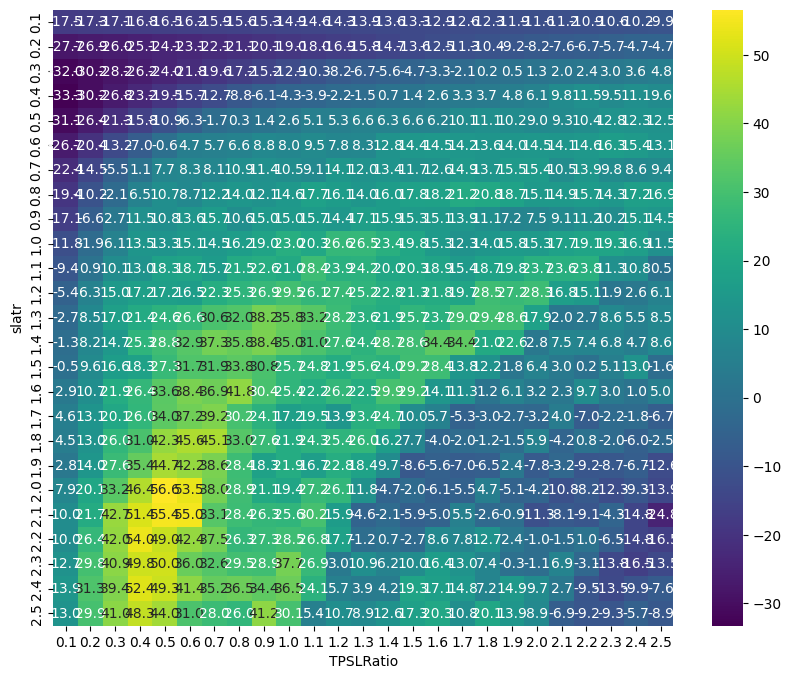

In [8]:
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()

In [ ]:
class AnalyzeData:
    def __init__(self, data_processor, MT4_directory_path=None, sleep_delay=0.100, max_retry_command_seconds=10, verbose=True):
        self.open_test_trades = False
        self.last_open_time = datetime.now(timezone.utc)
        self.last_modification_time = datetime.now(timezone.utc)
        self.data_processor = data_processor
        
        if MT4_directory_path:
            self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, max_retry_command_seconds, verbose=verbose)
            sleep(1)
            self.dwx.start()
            print("Account info:", self.dwx.account_info)
            self.dwx.subscribe_symbols(['EURUSD'])

    def analyze(self):
        # Obtener el DataFrame desde la instancia de getdf
        original_df = self.data_processor.get_data_frame()
        # Aquí puedes realizar análisis o manipulaciones con el DataFrame
        df = original_df.copy()
        df = df[df.High != df.Low]
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df["VWAP"] = ta.vwap(df.High, df.Low, df.Close, df.Tick_volume)
        df['RSI'] = ta.rsi(df.Close, length=16)
        my_bbands = ta.bbands(df.Close, length=14, std=2.0)
        df = df.join(my_bbands)
        df.dropna(inplace=True)
        print('FASE1')
        
        VWAPsignal = [0] * len(df)
        backcandles = 15

        for row in range(backcandles, len(df)):
            upt = 1
            dnt = 1
            for i in range(row-backcandles, row+1):
                if max(df.Open[i], df.Close[i]) >= df.VWAP[i]:
                    dnt = 0
                if min(df.Open[i], df.Close[i]) <= df.VWAP[i]:
                    upt = 0
            if upt == 1 and dnt == 1:
                VWAPsignal[row] = 3
            elif upt == 1:
                VWAPsignal[row] = 2
            elif dnt == 1:
                VWAPsignal[row] = 1

        df['VWAPSignal'] = VWAPsignal
        #print("Análisis del DataFrame:")
        #print(self.df.describe())  # Ejemplo de análisis: mostrar estadísticas descriptivas
        
        self.TotalSignal(df)
    def TotalSignal(self, df):
        def calculate_signal(l):
            if df.VWAPSignal[l] == 2 and df.Close[l] <= df['BBL_14_2.0'][l] and df.RSI[l] < 45:
                return 2
            if df.VWAPSignal[l] == 1 and df.Close[l] >= df['BBU_14_2.0'][l] and df.RSI[l] > 55:
                return 1
            return 0

        TotSignal = [0] * len(df)
        backcandles = 15
        for row in range(backcandles, len(df)):
            TotSignal[row] = calculate_signal(row)
        df['TotalSignal'] = TotSignal
        df[df.TotalSignal != 0].count()
        self.pointposbreak(df)
    def pointposbreak(self, df):
        def calculate_pointposbreak(x):
            if x['TotalSignal'] == 1:
                return x['High'] + 1e-4
            elif x['TotalSignal'] == 2:
                return x['Low'] - 1e-4
            else:
                return np.nan
        df['pointposbreak'] = df.apply(lambda row: calculate_pointposbreak(row), axis=1)
        df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=7)
        print(df)
        print('FASE2')
        return(df)
    def fitting_job(self, df):
        def SIGNAL():
            return df.TotalSignal
        class MyStrat(Strategy):
            initsize = 0.99
            mysize = initsize
            slatr = 1.0
            TPSLRatio = 1.0
            def init(self):
                super().init()
                self.signal1 = self.I(SIGNAL)

            def next(self):
                super().next()
                slatr = 1.0 * self.data.ATR[-1]
                TPSLRatio = 1.0

                if len(self.trades) > 0:
                    if self.trades[-1].is_long and self.data.RSI[-1] >= 90:
                        self.trades[-1].close()
                    elif self.trades[-1].is_short and self.data.RSI[-1] <= 10:
                        self.trades[-1].close()
                
                if self.signal1 == 2 and len(self.trades) == 0:
                   entry_price = self.data.Close[-1]
                   sl1 = entry_price - slatr
                   tp1 = entry_price + slatr * TPSLRatio
                   self.buy(sl=sl1, tp=tp1, size=self.mysize)
                elif self.signal1 == 1 and len(self.trades) == 0:
                   entry_price = self.data.Close[-1]
                   sl1 = entry_price + slatr
                   tp1 = entry_price - slatr * TPSLRatio
                   self.sell(sl=sl1, tp=tp1, size=self.mysize)
                   
        bt = Backtest(self.df, MyStrat, cash=1000, margin=1/30, commission=0.000)
        self.stats, self.heatmap = bt.optimize(slatr=[i/10 for i in range(10, 26)],
                                     TPSLRatio=[i/10 for i in range(10, 26)],
                                     maximize='Return [%]', max_tries=300,
                                     random_state=0,
                                     return_heatmap=True)
        
        slatrcoef = self.stats["_strategy"].slatr
        TPSLRatio_coef = self.stats["_strategy"].TPSLRatio
        print(slatrcoef, TPSLRatio_coef)
        with open("fitting_data_file.txt", "a") as file:
            file.write(f"NUEVO ANALISIS-----------------------------------------\n") 
            file.write(f"{slatrcoef}, {TPSLRatio_coef}, expected return, {self.stats['Return [%]']}\n")
            file.write(f"Duration, {self.stats['Duration']}\n") 
            file.write(f"Max Drawdown, {self.stats['Max. Drawdown [%]']}\n") 
            file.write(f"Equity Final [$], {self.stats['Equity Final [$]']}\n")   
            file.write(f"Equity Peak [$], {self.stats['Equity Peak [$]']}\n")   
            file.write(f"Return (Ann.) [%], {self.stats['Return (Ann.) [%]']}\n")   
            file.write(f"Max. Drawdown Duration, {self.stats['Max. Drawdown Duration']}\n")   
            file.write(f"Avg. Drawdown Duration, {self.stats['Avg. Drawdown Duration']}\n")   
            file.write(f"Win Rate [%], {self.stats['Win Rate [%]']}\n")   
            file.write(f"Max. Trade Duration, {self.stats['Max. Trade Duration']}\n")   
            file.write(f"Avg. Trade Duration, {self.stats['Avg. Trade Duration']}\n")   
            file.write(f"Max. Drawdown [%], {self.stats['Max. Drawdown [%]']}\n")   
        
        
# Uso de las clases
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()


processor = getdf(MT4_files_dir)
analyzer = AnalyzeData(processor, MT4_files_dir)  # Pasar la instancia de getdf a la nueva clase

# Esperar a que los datos estén listos y luego realizar el análisis

processed_df = analyzer.analyze() 
data = analyzer.fitting_job(processed_df)


In [ ]:
processor = getdf(MT4_files_dir)
while processor.dwx.ACTIVE:
    sleep(1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

class SmaStrategy:
    def __init__(self, data, sma_period_200=200, sma_period_5=5, stop_loss=0.004):
        self.data = data
        self.sma_period_200 = sma_period_200
        self.sma_period_5 = sma_period_5
        self.stop_loss = stop_loss
        self.cash = 100000
        self.initial_cash = self.cash
        self.position = 0
        self.operations = []
        self.portfolio_values = []
        self.sma_200 = self.data['close'].rolling(window=self.sma_period_200).mean()
        self.sma_5 = self.data['close'].rolling(window=self.sma_period_5).mean()

    def run(self):
        entry_price = 0
        for i in range(max(self.sma_period_200, self.sma_period_5), len(self.data)):
            date = self.data.index[i]
            close_price = self.data['close'].iloc[i]
            open_price = self.data['open'].iloc[i]
            sma_200_value = self.sma_200.iloc[i]
            sma_5_value = self.sma_5.iloc[i]

            if self.position == 0:
                if close_price > sma_200_value and \
                   self.data['close'].iloc[i-1] < self.data['close'].iloc[i-2] < self.data['close'].iloc[i-34] < self.data['close'].iloc[i-4]:
                    sl_price = self.data['close'].iloc[i-1] * (1 - self.stop_loss)
                    entry_price = open_price
                    size = 1000
                    self.position = size
                    self.cash -= size * close_price
                    self.operations.append({
                        'Fecha entrada': date,
                        'Precio Entrada': entry_price,
                        'Fecha Salida': None,
                        'Precio Salida': None,
                        'PnL': 0,
                        'Valor Cuenta': self.cash + self.position * close_price
                    })
                    self.sl_price = sl_price
            else:
                if close_price >= sma_5_value or close_price <= self.sl_price:
                    pnl = self.position * (close_price - entry_price)
                    self.cash += self.position * close_price
                    self.operations[-1]['Fecha Salida'] = date
                    self.operations[-1]['Precio Salida'] = close_price
                    self.operations[-1]['PnL'] = pnl
                    self.operations[-1]['Valor Cuenta'] = self.cash
                    self.position = 0

    def calculate_performance(self):
        cumulative_returns = self.cash - self.initial_cash
        max_drawdown = 0  # Aquí debería implementarse la lógica para calcular el drawdown máximo
        return {
            'Numero de operaciones': len(self.operations),
            'Rentabilidad': round(cumulative_returns, 2),
            'Drawdown maximo': max_drawdown
        }

    def calculate_win_loss_ratio(self):
        wins = sum(op['PnL'] > 0 for op in self.operations)
        losses = sum(op['PnL'] <= 0 for op in self.operations)
        win_loss_ratio = round(wins / (wins + losses), 4) if (wins + losses) > 0 else float('inf')
        return {
            'Operaciones Ganadoras': wins,
            'Operaciones Perdedoras': losses,
            'Win/Loss Ratio': win_loss_ratio
        }

def calculate_volatility(data, period=14):
    returns = data['close'].pct_change()
    volatility = returns.rolling(window=period).std()
    return volatility

if __name__ == '__main__':
    dataframe = pd.read_csv('SP500.csv', parse_dates=True, index_col='time')
    dataframe['Volatility'] = calculate_volatility(dataframe)

    strategy = SmaStrategy(dataframe)
    strategy.run()
    performance = strategy.calculate_performance()
    win_loss_ratio = strategy.calculate_win_loss_ratio()

    print("Resultados de la estrategia:")
    print(f"Rentabilidad: {performance['Rentabilidad']}")
    print(f"Drawdown maximo: {performance['Drawdown maximo']}")
    print(f"Numero de operaciones: {performance['Numero de operaciones']}")
    print(f"Operaciones Ganadoras: {win_loss_ratio['Operaciones Ganadoras']}")

    # Convertir valores del portafolio a DataFrame y graficar
    # Esta sección necesita ser implementada basada en cómo se actualizan los valores del portafolio en `self.operations`

In [9]:
class getdf():
    def __init__(self, MT4_directory_path, 
                 sleep_delay=1,             # 5 ms for time.sleep()
                 max_retry_command_seconds=10,  # retry to send the commend for 10 seconds if not successful. 
                 verbose=True, ):
        self.data_event = Event()
        self.dfstream = None

        self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, 
                              max_retry_command_seconds, verbose=verbose)
        sleep(1)
        self.dwx.start()
        end = datetime.now(timezone.utc)
        start = end - timedelta(days=300)  # last 100 days
        self.dwx.get_historic_data('AUDCAD', 'M5', start.timestamp(), end.timestamp())
        
    def on_historic_data(self, symbol, time_frame, data):
        data_list = []

        for date_str, values in data.items():
            date = datetime.strptime(date_str, "%Y.%m.%d %H:%M")
            data_dict = {
                'Date': date,
                'Open': values['open'],
                'High': values['high'],
                'Low': values['low'],
                'Close': values['close'],
                'Tick_volume': values['tick_volume']
            }
            data_list.append(data_dict)
        
        self.dfstream = pd.DataFrame(data_list)
        print(self.dfstream)
        self.data_event.set()  # Signal that data is ready
        
    def on_message(self, message):
        if message['type'] == 'ERROR':
            print(message['type'], '|', message['error_type'], '|', message['description'])
        elif message['type'] == 'INFO':
            print(message['type'], '|', message['message'])
    
    def get_data_frame(self):
        self.data_event.wait()  # Wait until data is ready
        return self.dfstream

# Example usage
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

processor = getdf(MT4_files_dir)

# Wait for data to be processed and retrieve the DataFrame
df = processor.get_data_frame()


Exception in thread Thread-56 (check_market_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 258, in check_market_data
    self.event_handler.on_tick(symbol,
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_tick'


INFO | Successfully read historic data for AUDCAD_M5.
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-03 15:55:00  0.86402  0.86409  0.86371  0.86381        661.0
1     2023-10-03 16:00:00  0.86384  0.86418  0.86340  0.86411        909.0
2     2023-10-03 16:05:00  0.86411  0.86423  0.86372  0.86373        812.0
3     2023-10-03 16:10:00  0.86373  0.86380  0.86320  0.86322        730.0
4     2023-10-03 16:15:00  0.86322  0.86325  0.86279  0.86316        881.0
...                   ...      ...      ...      ...      ...          ...
60898 2024-07-29 15:30:00  0.90579  0.90579  0.90541  0.90546        454.0
60899 2024-07-29 15:35:00  0.90547  0.90553  0.90537  0.90545        417.0
60900 2024-07-29 15:40:00  0.90544  0.90552  0.90514  0.90519        487.0
60901 2024-07-29 15:45:00  0.90519  0.90534  0.90514  0.90522        422.0
60902 2024-07-29 15:50:00  0.90522  0.90534  0.90513  0.90514        421.0

[60903 rows x 6 columns]


Exception in thread Thread-58 (check_open_orders):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 197, in check_open_orders
    self.event_handler.on_order_event()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_order_event'


Order removed:  {'magic': 0, 'symbol': 'GBPJPY', 'lots': 1.0, 'type': 'sell', 'open_price': 197.729, 'open_time': '2024.07.29 18:54:12', 'SL': 0.0, 'TP': 0.0, 'pnl': -150.04, 'swap': 0.0, 'comment': ''}
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-03 21:00:00  1.04690  1.04700  1.04660  1.04665        207.0
1     2023-10-03 21:05:00  1.04670  1.04724  1.04648  1.04651        310.0
2     2023-10-03 21:10:00  1.04650  1.04656  1.04630  1.04646        240.0
3     2023-10-03 21:15:00  1.04645  1.04645  1.04595  1.04634        222.0
4     2023-10-03 21:20:00  1.04634  1.04664  1.04628  1.04655        149.0
...                   ...      ...      ...      ...      ...          ...
60873 2024-07-29 19:35:00  1.08196  1.08207  1.08193  1.08199        136.0
60874 2024-07-29 19:40:00  1.08199  1.08202  1.08192  1.08197        128.0
60875 2024-07-29 19:45:00  1.08197  1.08223  1.08196  1.08220        130.0
60876 2024-07-29 19:50:00  1.08223  1.08235  1.

In [16]:
import json
import os
import pandas as pd
from time import sleep
from threading import Thread
from os.path import join, exists
from traceback import print_exc
from random import random
from datetime import datetime, timezone, timedelta, date
from api.dwx_client import dwx_client
import numpy as np
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from backtesting import Strategy, Backtest
from apscheduler.schedulers.blocking import BlockingScheduler
import sys
from threading import Event


class getdf():
    def __init__(self, MT4_directory_path, 
                 sleep_delay=1,             # 5 ms for time.sleep()
                 max_retry_command_seconds=10,  # retry to send the commend for 10 seconds if not successful. 
                 verbose=True, ):
        self.data_event = Event()
        self.dfstream = None

        self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, 
                              max_retry_command_seconds, verbose=verbose)
        sleep(1)
        self.dwx.start()
       
        end = datetime.now(timezone.utc) + timedelta(hours=4)
        start = end - timedelta(days=300)  # últimos 100 días
        self.dwx.get_historic_data('EURUSD', 'M5', start.timestamp(), end.timestamp())    
  

    def on_historic_data(self, symbol, time_frame, data):
        data_list = []

        for date_str, values in data.items():
            date = datetime.strptime(date_str, "%Y.%m.%d %H:%M")
            data_dict = {
                'Date': date,
                'Open': values['open'],
                'High': values['high'],
                'Low': values['low'],
                'Close': values['close'],
                'Tick_volume': values['tick_volume']
            }
            data_list.append(data_dict)
        
        self.dfstream = pd.DataFrame(data_list)
        print("Historic DataFrame:")
        print(self.dfstream)
        
        self.data_event.set() 
        
    def on_bar_data(self, symbol, time_frame, time, open_price, high, low, close_price, tick_volume):
        data1 = {
            'Date': [time],
            'Open': [open_price],
            'High': [high],
            'Low': [low],
            'Close': [close_price],
            'Tick_volume': [tick_volume]
        }
        
        df1 = pd.DataFrame(data1)
 
        df1['Date'] = pd.to_datetime(df1['Date']).dt.tz_localize('UTC').dt.strftime('%Y-%m-%d %H:%M:%S')
        print(df1)
        return df1
    def on_message(self, message):
        if message['type'] == 'ERROR':
            print(message['type'], '|', message['error_type'], '|', message['description'])
        elif message['type'] == 'INFO':
            print(message['type'], '|', message['message'])
            
    def get_data_frame(self):
        self.data_event.wait()  # Wait until data is ready
        return self.dfstream

# Example usage
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

data_processor1 = getdf(MT4_files_dir)

# Wait for data to be processed and retrieve the DataFrame
df = data_processor1.get_data_frame()





Exception in thread Thread-100 (check_market_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 258, in check_market_data
    self.event_handler.on_tick(symbol,
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_tick'


INFO | Successfully read historic data for EURUSD_M5.
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-03 20:45:00  1.04670  1.04704  1.04663  1.04696        246.0
1     2023-10-03 20:50:00  1.04696  1.04696  1.04665  1.04666        180.0
2     2023-10-03 20:55:00  1.04666  1.04705  1.04634  1.04690        220.0
3     2023-10-03 21:00:00  1.04690  1.04700  1.04660  1.04665        207.0
4     2023-10-03 21:05:00  1.04670  1.04724  1.04648  1.04651        310.0
...                   ...      ...      ...      ...      ...          ...
60873 2024-07-29 19:20:00  1.08167  1.08173  1.08165  1.08167         88.0
60874 2024-07-29 19:25:00  1.08167  1.08173  1.08152  1.08173        160.0
60875 2024-07-29 19:30:00  1.08176  1.08201  1.08171  1.08197        170.0
60876 2024-07-29 19:35:00  1.08196  1.08207  1.08193  1.08199        136.0
60877 2024-07-29 19:40:00  1.08199  1.08202  1.08195  1.08198         90.0

[60878 rows x 6 columns]


INFO | Successfully read historic data for EURUSD_M5.
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-03 20:45:00  1.04670  1.04704  1.04663  1.04696        246.0
1     2023-10-03 20:50:00  1.04696  1.04696  1.04665  1.04666        180.0
2     2023-10-03 20:55:00  1.04666  1.04705  1.04634  1.04690        220.0
3     2023-10-03 21:00:00  1.04690  1.04700  1.04660  1.04665        207.0
4     2023-10-03 21:05:00  1.04670  1.04724  1.04648  1.04651        310.0
...                   ...      ...      ...      ...      ...          ...
60873 2024-07-29 19:20:00  1.08167  1.08173  1.08165  1.08167         88.0
60874 2024-07-29 19:25:00  1.08167  1.08173  1.08152  1.08173        160.0
60875 2024-07-29 19:30:00  1.08176  1.08201  1.08171  1.08197        170.0
60876 2024-07-29 19:35:00  1.08196  1.08207  1.08193  1.08199        136.0
60877 2024-07-29 19:40:00  1.08199  1.08202  1.08195  1.08198         90.0

[60878 rows x 6 columns]


Exception in thread Thread-102 (check_open_orders):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 197, in check_open_orders
    self.event_handler.on_order_event()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_order_event'


Order removed:  {'magic': 0, 'symbol': 'GBPJPY', 'lots': 1.0, 'type': 'sell', 'open_price': 197.729, 'open_time': '2024.07.29 18:54:12', 'SL': 0.0, 'TP': 0.0, 'pnl': -151.84, 'swap': 0.0, 'comment': ''}
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-03 21:00:00  1.04690  1.04700  1.04660  1.04665        207.0
1     2023-10-03 21:05:00  1.04670  1.04724  1.04648  1.04651        310.0
2     2023-10-03 21:10:00  1.04650  1.04656  1.04630  1.04646        240.0
3     2023-10-03 21:15:00  1.04645  1.04645  1.04595  1.04634        222.0
4     2023-10-03 21:20:00  1.04634  1.04664  1.04628  1.04655        149.0
...                   ...      ...      ...      ...      ...          ...
60873 2024-07-29 19:35:00  1.08196  1.08207  1.08193  1.08199        136.0
60874 2024-07-29 19:40:00  1.08199  1.08202  1.08192  1.08197        128.0
60875 2024-07-29 19:45:00  1.08197  1.08223  1.08196  1.08220        130.0
60876 2024-07-29 19:50:00  

In [12]:
class processor2:

    def __init__(self, data_processor1, MT4_directory_path, sleep_delay=0.005, max_retry_command_seconds=10, verbose=True):
        try:
            self.open_test_trades = True
            self.last_open_time = datetime.now(timezone.utc)
            self.last_modification_time = datetime.now(timezone.utc)
            # Assuming dwx_client is defined elsewhere and correctly imported
            self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, max_retry_command_seconds, verbose=verbose)
            sleep(1)
            self.dwx.start()
            print("Account info:", self.dwx.account_info)
            
            # Initialize dfstream here
            self.slatrcoef = 0
            self.TPSLRatio_coef = 0
            self.initsize = 0.99
            self.mysize = self.initsize
        except Exception as e:
            print(f"Error during initialization: {e}")
    def on_bar_data(self, symbol, time_frame, time, open_price, high, low, close_price, tick_volume):
        data1 = {
            'Date': [time],
            'Open': [open_price],
            'High': [high],
            'Low': [low],
            'Close': [close_price],
            'Tick_volume': [tick_volume]
        }
        
        df1 = pd.DataFrame(data1)
 
        df1['Date'] = pd.to_datetime(df1['Date']).dt.tz_localize('UTC').dt.strftime('%Y-%m-%d %H:%M:%S')
        print(df1)
        return df1
    
MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

data_processor2 = processor2(MT4_files_dir)

# Wait for data to be processed and retrieve the DataFrame
df = data_processor2.on_bar_data()

TypeError: processor2.__init__() missing 1 required positional argument: 'MT4_directory_path'

In [ ]:
class tick_processor:

    def __init__(self, data_processor1, MT4_directory_path, sleep_delay=0.005, max_retry_command_seconds=10, verbose=True):
        try:
            self.open_test_trades = True
            self.last_open_time = datetime.now(timezone.utc)
            self.last_modification_time = datetime.now(timezone.utc)
            # Assuming dwx_client is defined elsewhere and correctly imported
            self.dwx = dwx_client(self, MT4_directory_path, sleep_delay, max_retry_command_seconds, verbose=verbose)
            sleep(1)
            self.dwx.start()
            print("Account info:", self.dwx.account_info)
            
            # Initialize dfstream here
            self.slatrcoef = 0
            self.TPSLRatio_coef = 0
            self.initsize = 0.99
            self.mysize = self.initsize
        except Exception as e:
            print(f"Error during initialization: {e}")

    def on_bar_data(self, symbol, time_frame, time, open_price, high, low, close_price, tick_volume):
        
        try:
            original_df = self.data_processor1.get_data_frame()
            df = original_df.copy()
            data1 = {
                'Date': [time],
                'Open': [open_price],
                'High': [high],
                'Low': [low],
                'Close': [close_price],
                'Tick_volume': [tick_volume]
            }
            
            df1 = pd.DataFrame(data1)
            print(df1)
            df1['Date'] = pd.to_datetime(df1['Date']).dt.tz_localize('UTC').dt.strftime('%Y-%m-%d %H:%M:%S')
            df = pd.concat([df, df1], ignore_index=True)
            
            print("New Bar DataFrame:")
            print(df1)
            print("Updated DataFrame:")
            print(df)
            print('on_bar_data:', symbol, time_frame, datetime.now(timezone.utc), time, open_price, high, low, close_price)
            df["VWAP"] = ta.vwap(df.High, df.Low, df.Close, df.Tick_volume)
            df['RSI'] = ta.rsi(df.Close, length=16)
            my_bbands = ta.bbands(df.Close, length=14, std=2.0)
            df = df.join(my_bbands)
            df.dropna(inplace=True)
            df['ATR'] = ta.atr(df.High, df.Low, df.Close, length=7)
            print('FASE1')
            
            VWAPsignal = [0] * len(df)
            backcandles = 15

            for row in range(backcandles, len(df)):
                upt = 1
                dnt = 1
                for i in range(row-backcandles, row+1):
                    if max(df.Open.iloc[i], df.Close.iloc[i]) >= df.VWAP.iloc[i]:
                        dnt = 0
                    if min(df.Open.iloc[i], df.Close.iloc[i]) <= df.VWAP.iloc[i]:
                        upt = 0
                if upt == 1 and dnt == 1:
                    VWAPsignal[row] = 3
                elif upt == 1:
                    VWAPsignal[row] = 2
                elif dnt == 1:
                    VWAPsignal[row] = 1

            df['VWAPSignal'] = VWAPsignal
            self.dfstream1 = df
            
        except Exception as e:
            print(f"Error in on_bar_data: {e}")

    def total_signal(self, dfstream):
        try:
            def calculate_signal(l):
                if dfstream.VWAPSignal.iloc[l] == 2 and dfstream.Close.iloc[l] <= dfstream['BBL_14_2.0'].iloc[l] and dfstream.RSI.iloc[l] < 45:
                    return 2
                if dfstream.VWAPSignal.iloc[l] == 1 and dfstream.Close.iloc[l] >= dfstream['BBU_14_2.0'].iloc[l] and dfstream.RSI.iloc[l] > 55:
                    return 1
                return 0

            TotSignal = [0] * len(dfstream)
            backcandles = 15
            for row in range(backcandles, len(dfstream)):
                TotSignal[row] = calculate_signal(row)
            dfstream['TotalSignal'] = TotSignal
            dfstream[dfstream.TotalSignal != 0].count()
            print("FASE2")
            return self.dfstream
        except Exception as e:
            print(f"Error in total_signal: {e}")

    def on_tick(self, symbol, bid, ask, dfstream1):
        try:
            #necesito poder usar el dataframe de on_bar_data aqui para hacer funcionar oon_tick necesito usar dfstream1 sin tener que hacer un nuevo on_bar_data
            signal = self.total_signal(self.dfstream1)
            self.dfstream = self.dfstream1
            print("FASE3")
            print(self.dfstream)
          
            slatr = 1.0 * self.dfstream['ATR'].iloc[-1] * self.slatrcoef
            TPSLRatio = self.TPSLRatio_coef
            
            # Close open trades under certain conditions
            for ticket in self.dwx.open_orders.keys():
                trade = self.dwx.open_orders[ticket]
                if trade['type'] == 'buy' and self.dfstream['RSI'].iloc[-1] >= 90:
                    self.dwx.close_order(ticket)
                elif trade['type'] == 'sell' and self.dfstream['RSI'].iloc[-1] <= 10:
                    self.dwx.close_order(ticket)

            # Open new trades based on the signal
            signal = self.dfstream['TotalSignal'].iloc[-1]
            if signal == 2:  # Signal to buy
                entry_price = self.dfstream.Close.iloc[-1]
                sl1 = entry_price - slatr
                tp1 = entry_price + slatr * TPSLRatio
                self.dwx.open_order(symbol=symbol, order_type='buy', price=ask, sl=sl1, tp=tp1, lots=self.mysize)
            elif signal == 1:  # Signal to sell
                entry_price = self.dfstream.Close.iloc[-1]
                sl1 = entry_price + slatr
                tp1 = entry_price - slatr * TPSLRatio
                self.dwx.open_order(symbol=symbol, order_type='sell', price=bid, sl=sl1, tp=tp1, lots=self.mysize)
        except Exception as e:
            print(f"Error in on_tick: {e}")

    def on_message(self, message):
        try:
            if message['type'] == 'ERROR':
                print(message['type'], '|', message['error_type'], '|', message['description'])
            elif message['type'] == 'INFO':
                print(message['type'], '|', message['message'])
        except Exception as e:
            print(f"Error in on_message: {e}")

    def on_order_event(self):
        try:
            print(f'on_order_event. open_orders: {len(self.dwx.open_orders)} open orders')
        except Exception as e:
            print(f"Error in on_order_event: {e}")

    def get_dwx(self):
        return self.dwx

MT4_files_dir = r'C:\Users\guill\AppData\Roaming\MetaQuotes\Terminal\6C3C6A11D1C3791DD4DBF45421BF8028\MQL5\Files'
if not exists(MT4_files_dir):
    print('ERROR: metatrader_dir_path does not exist!')
    sys.exit()

data_processor1 = getdf(MT4_files_dir)
processor = tick_processor(data_processor1, MT4_files_dir)

Exception in thread Thread-36 (check_market_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 258, in check_market_data
    self.event_handler.on_tick(symbol,
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_tick'


Account info: {'name': 'Guillermo Fabian Guerra Algañaraz', 'number': -1294900752, 'currency': 'EUR', 'leverage': 200, 'free_margin': 7322.26, 'balance': 7322.26, 'equity': 7322.26}
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'


Exception in thread Thread-44 (check_historic_data):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 325, in check_historic_data
    self.event_handler.on_historic_data(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'tick_processor' object has no attribute 'on_historic_data'


INFO | Successfully read historic data for EURUSD_M5.
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
INFO | Successfully read historic data for EURUSD_M5.
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Historic DataFrame:
                     Date     Open     High      Low    Close  Tick_volume
0     2023-10-03 16:30:00  1.04695  1.04718  1.04665  1.04701        501.0
1     2023-10-03 16:35:00  1.04701  1.04753  1.04673  1.04750        535.0
2     2023-10-03 16:40:00  1.04751  1.04830  1.04744  1.04812        560.0
3   

Exception in thread Thread-38 (check_open_orders):
Traceback (most recent call last):
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\guill\Desktop\Trading\Proyectos de programacion\robot\api\dwx_client.py", line 197, in check_open_orders
    self.event_handler.on_order_event()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'getdf' object has no attribute 'on_order_event'


New order:  {'magic': 0, 'symbol': 'GBPJPY', 'lots': 1.0, 'type': 'sell', 'open_price': 197.729, 'open_time': '2024.07.29 18:54:12', 'SL': 0.0, 'TP': 0.0, 'pnl': -10.81, 'swap': 0.0, 'comment': ''}
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'tick_processor' object has no attribute 'dfstream1'
Error in on_tick: 'ti